In [1]:
import numpy as np
import pandas as pd
import torch

# Visualization
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from pandas.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D

# Feature Engineering
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelEncoder

# Machine Learning
import sklearn.ensemble as ske
from sklearn import datasets, model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Grid Search
import scipy.stats as st
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

# Metrics
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, roc_auc_score, classification_report

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# 1. Data Exploration

In [2]:
# Load column names
columns = [line.strip() for line in open('census-bureau.columns')]

# Load data
df = pd.read_csv('census-bureau.data', header=None, names=columns, na_values='?')

# Quick look
print(df.head())
print(df.info())
print(df.describe())

   age                 class of worker  detailed industry recode  \
0   73                 Not in universe                         0   
1   58  Self-employed-not incorporated                         4   
2   18                 Not in universe                         0   
3    9                 Not in universe                         0   
4   10                 Not in universe                         0   

   detailed occupation recode                   education  wage per hour  \
0                           0        High school graduate              0   
1                          34  Some college but no degree              0   
2                           0                  10th grade              0   
3                           0                    Children              0   
4                           0                    Children              0   

  enroll in edu inst last wk   marital stat          major industry code  \
0            Not in universe        Widowed  Not in univer

Features Visualization

In [32]:
import math
def plots(dataset, cols=3, width=18, height=5, hspace=0.4, wspace=0.4):
    plt.style.use('seaborn-v0_8-whitegrid')

    n_cols = dataset.shape[1]
    rows = math.ceil(n_cols / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(width, height*rows))
    axes = axes.flatten()  # Flatten to 1D for easy indexing

    for i, col in enumerate(dataset.columns):
        ax = axes[i]
        ax.set_title(col, fontsize=10)

        if pd.api.types.is_numeric_dtype(dataset[col]):
            sns.histplot(dataset[col].dropna(), kde=True, ax=ax, color="steelblue")
        else:
            # generate a color palette based on number of unique categories
            n_cat = dataset[col].nunique()
            palette = sns.color_palette("tab20", n_cat)  # tab20 or any other palette
            sns.countplot(
                y=col,
                data=dataset,
                order=dataset[col].value_counts().index,
                ax=ax,
                palette=palette
            )
            # truncate long labels
            labels = [s.get_text()[:15] for s in ax.get_yticklabels()]
            ax.set_yticklabels(labels, fontsize=8)

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()

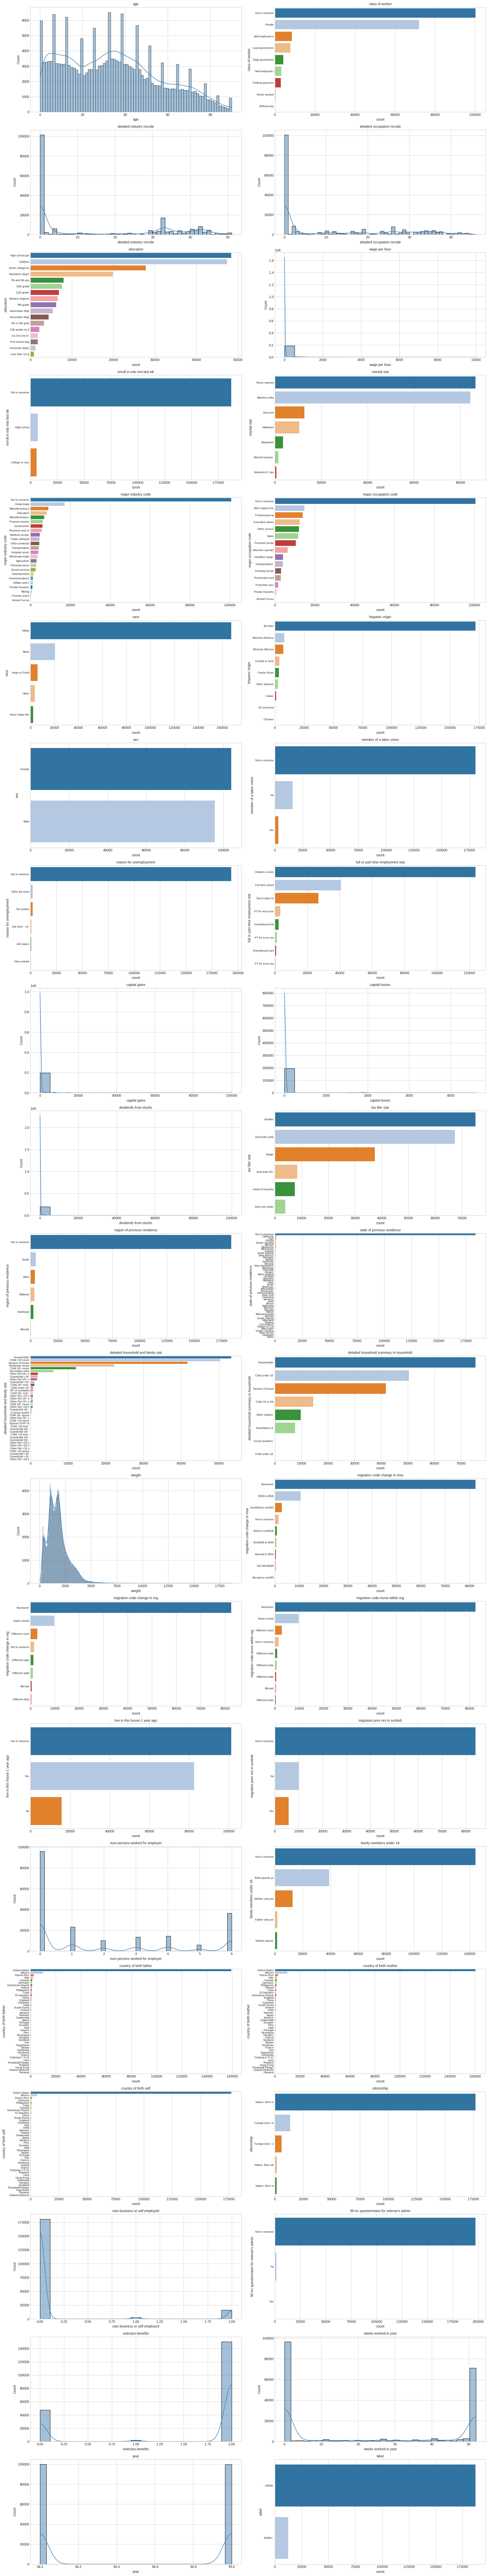

In [33]:
# Single Feature
plots(df, cols=2, width=20, hspace=0.45, wspace=0.5)

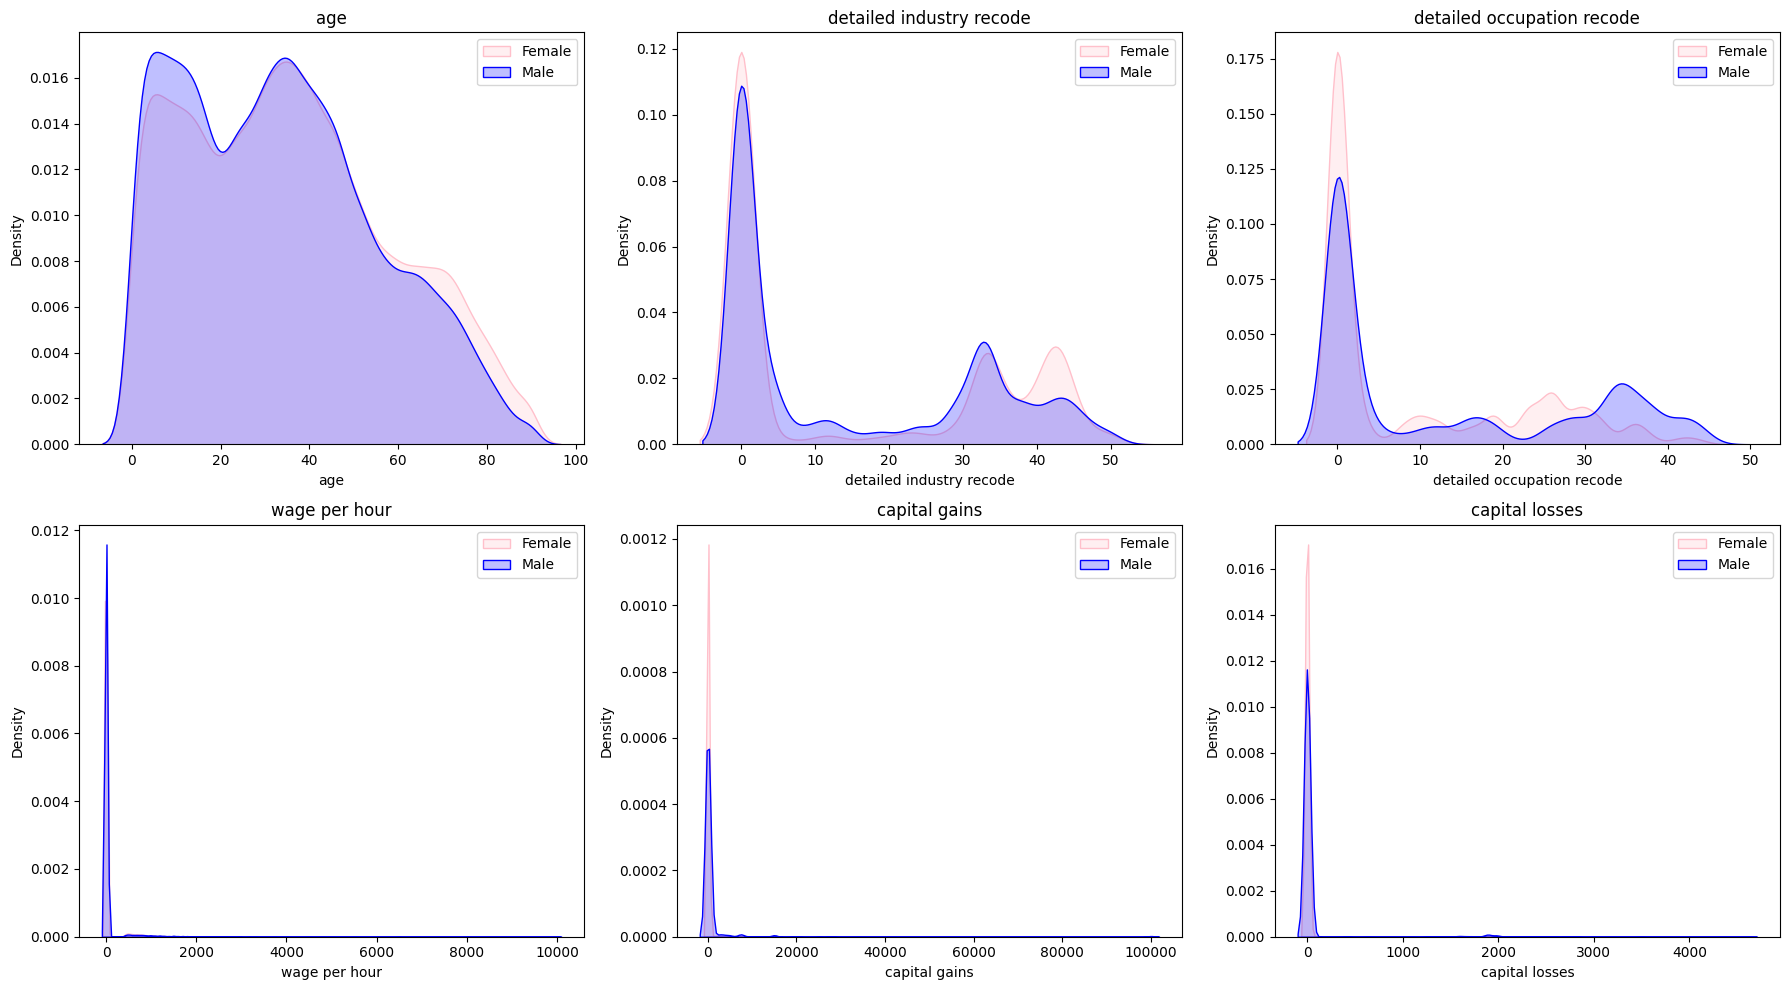

In [63]:
num_feat = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(18, 10))

for i, c in enumerate(num_feat[:6]):  # first 6 numerical features
    plt.subplot(2, 3, i+1)
    sns.kdeplot(df[df['sex'] == 'Female'][c], shade=True, color='pink', label='Female')
    sns.kdeplot(df[df['sex'] == 'Male'][c], shade=True, color='blue', label='Male')
    plt.title(c)
    plt.legend()

plt.tight_layout()
plt.show()

In [17]:
print(f"Ratio above 50k : {(df['label'] == '50000+.').astype('int').sum() / df.shape[0] * 100 :.2f}%")

Ratio above 50k : 6.21%


only 6.21% of data has label "50000+". For the binary classification problem it is highly unbalanced, therefore accuracy might not be a good metrics for model evaluation.

<Axes: >

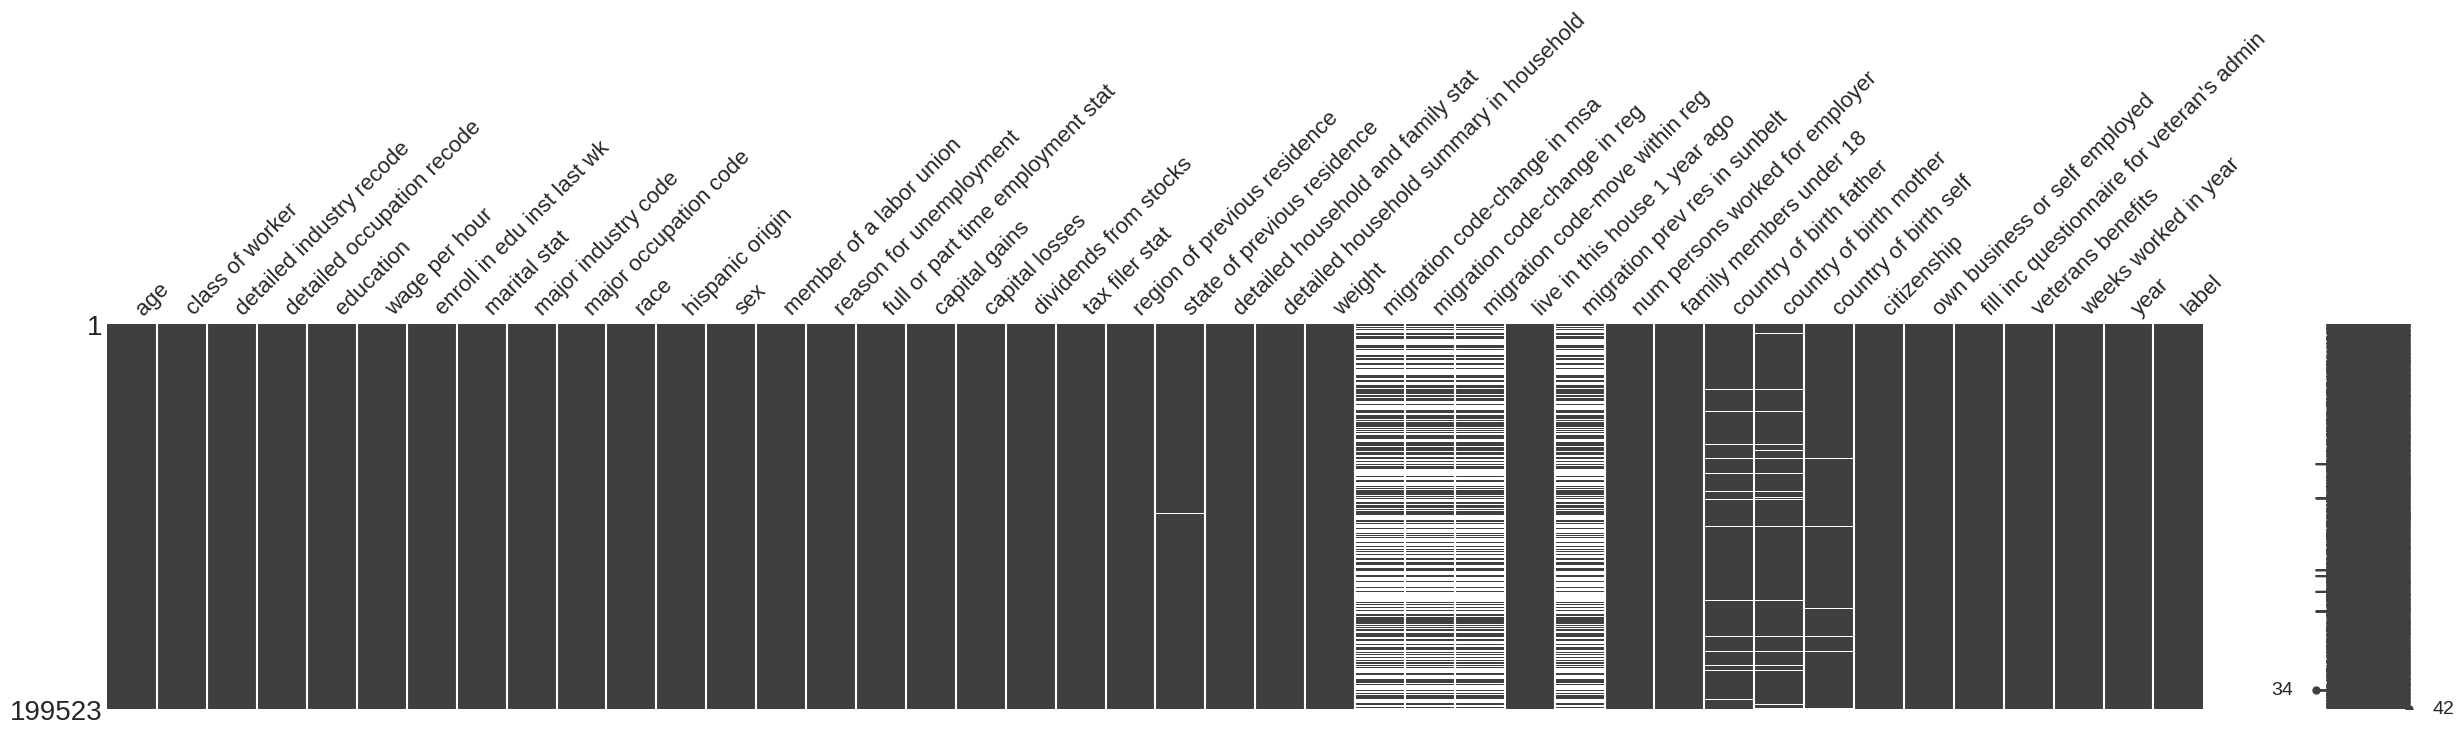

In [34]:
# Missing Values
msno.matrix(df, figsize=(30, 5))

<Axes: >

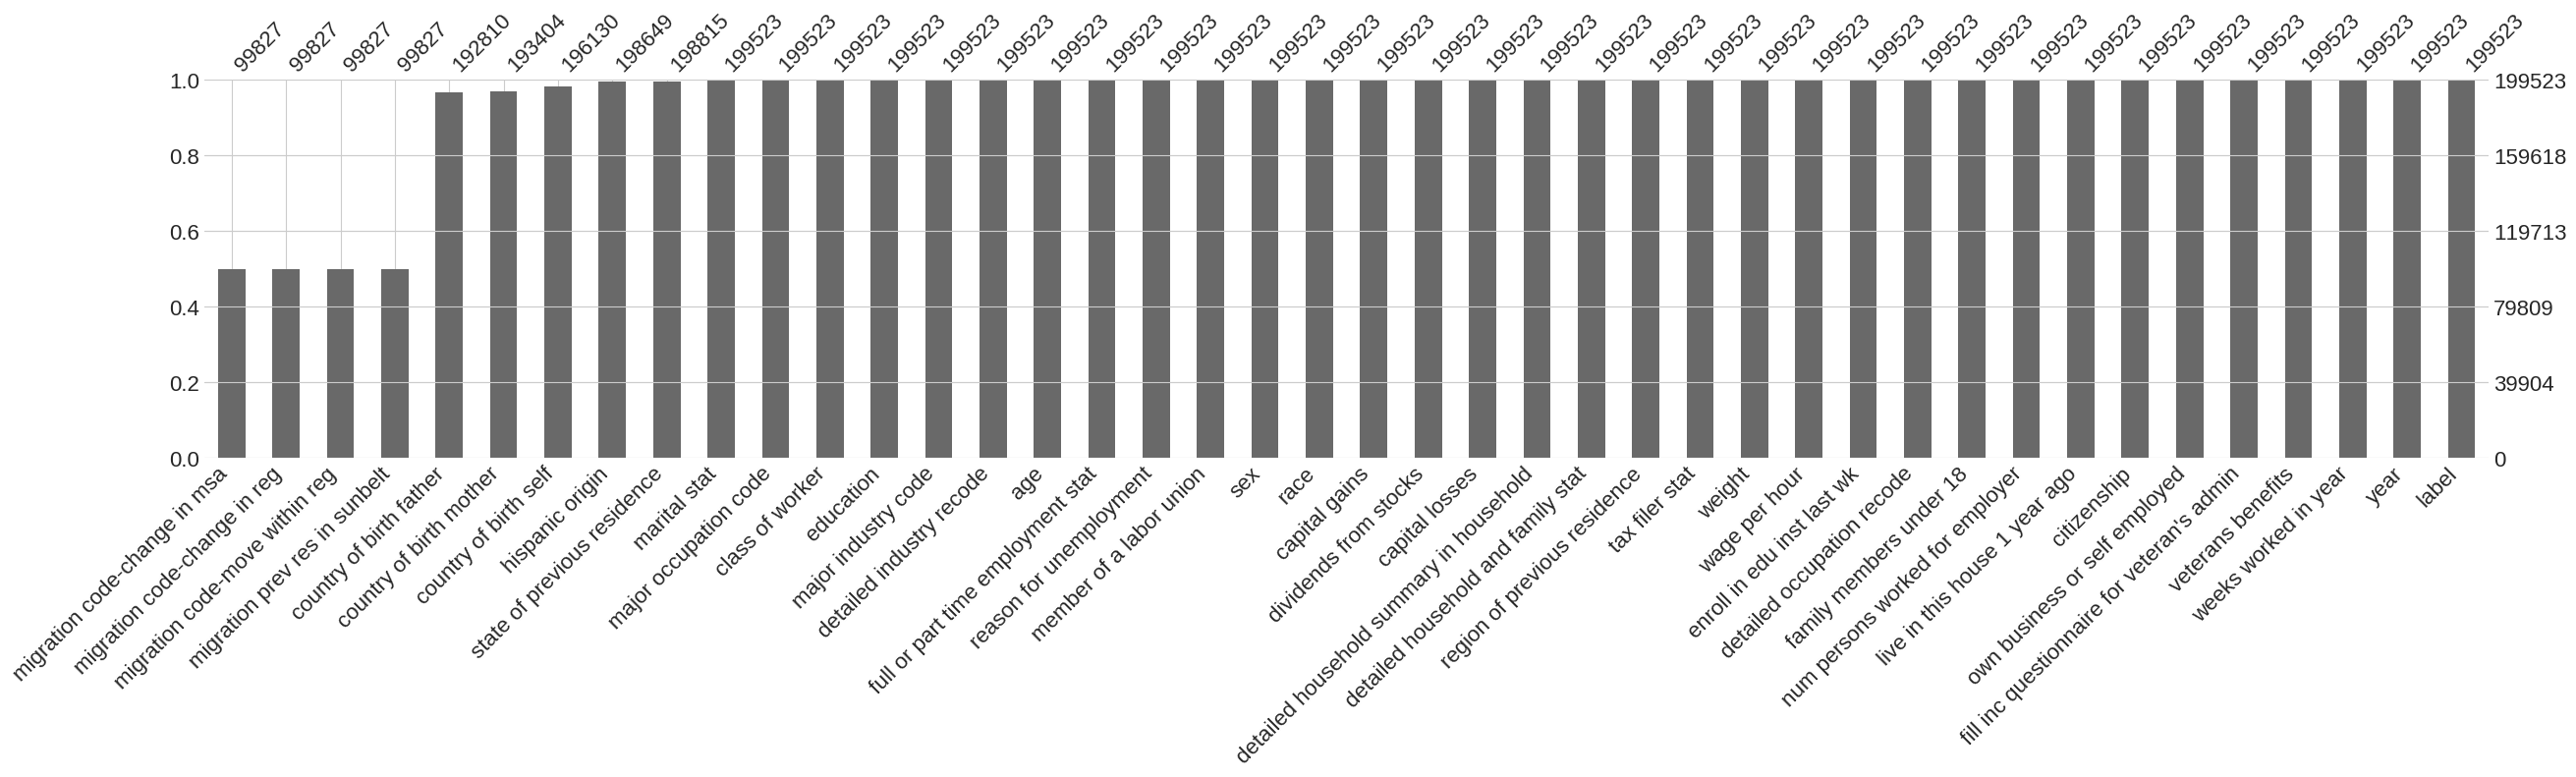

In [35]:
msno.bar(df, sort='ascending', figsize=(30, 5))

About 50% of 4 migration related features are missing values. We choose to drop these columns to prevent noisy training data set.

# 2. Classifier: Random Forest
We promptly use pandas.get_dummies() for feature encoding and create a simple random forest classifier for an overview.


In [3]:
# change label to 0/1
df['label'] = df['label'].str.strip()
df['label'] = df['label'].apply(lambda x: 1 if x == '50000+.' else 0)

# replace placeholder with NA
#df.replace(['Not in universe', '?', 'Not in universe under 1 year old'], pd.NA, inplace=True)
df.replace(['?'], pd.NA, inplace=True)



In [4]:
# get categorical columns
categorical_cols = [
    'class of worker', 'detailed industry recode', 'detailed occupation recode',
    'education', 'enroll in edu inst last wk', 'marital stat', 'major industry code',
    'major occupation code', 'race', 'hispanic origin', 'sex', 'member of a labor union',
    'reason for unemployment', 'full or part time employment stat', 'tax filer stat',
    'region of previous residence', 'state of previous residence',
    'detailed household and family stat', 'detailed household summary in household',
    'migration code-change in msa', 'migration code-change in reg',
    'migration code-move within reg', 'live in this house 1 year ago', 'migration prev res in sunbelt',
    'family members under 18', 'country of birth father', 'country of birth mother', 'country of birth self',
    'citizenship', 'own business or self employed', 'fill inc questionnaire for veteran\'s admin',
    'veterans benefits'
]

# one-hot encoding categorical columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, dummy_na=True)

# separate features, target, and weights
X = df_encoded.drop(['label', 'weight'], axis=1)
y = df_encoded['label']
weights = df_encoded['weight']

# train test split
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42, stratify=y
)


In [27]:
# train a random forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train, sample_weight=w_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     37429
           1       0.73      0.38      0.50      2476

    accuracy                           0.95     39905
   macro avg       0.85      0.68      0.74     39905
weighted avg       0.95      0.95      0.95     39905

ROC AUC: 0.9429566642525878


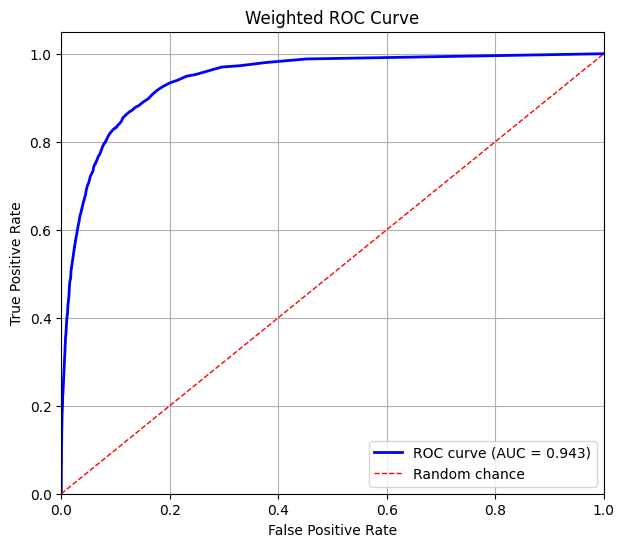

In [46]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 3. Classifier: Logistic Regression

In [9]:
lr_clf = LogisticRegression(
    class_weight='balanced',  # handle imbalance
    max_iter=1000,
    random_state=42
)

lr_clf.fit(X_train, y_train, sample_weight=w_train)

y_pred = lr_clf.predict(X_test)
y_prob = lr_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     37429
           1       0.27      0.90      0.42      2476

    accuracy                           0.84     39905
   macro avg       0.63      0.87      0.66     39905
weighted avg       0.95      0.84      0.88     39905

ROC AUC: 0.9422833912305757


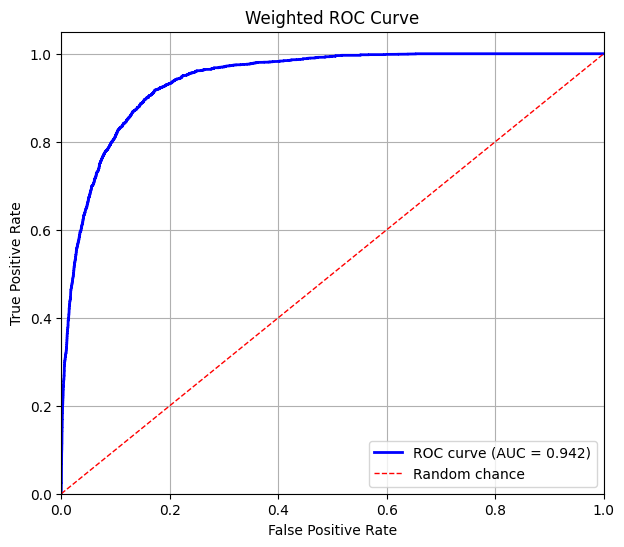

In [10]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4. Classifier: Extreme Gradient Boosting(XGB)

In [13]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train==0).sum() / (y_train==1).sum(),  # handle imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_clf.fit(X_train.values, y_train.values, sample_weight=w_train.values)

In [19]:
y_pred = xgb_clf.predict(X_test)
y_prob = xgb_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     37429
           1       0.33      0.88      0.48      2476

    accuracy                           0.88     39905
   macro avg       0.66      0.88      0.70     39905
weighted avg       0.95      0.88      0.90     39905

ROC AUC: 0.9524893166916318


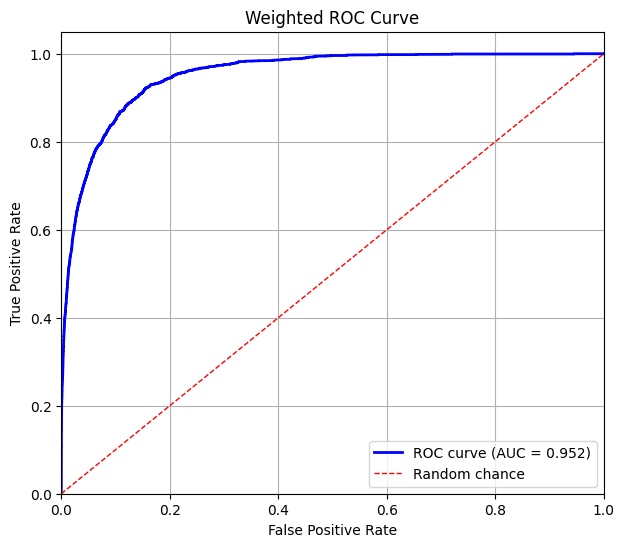

In [20]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 5. Classifier: Neural Network(MLP)

In [23]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    max_iter=100,
    random_state=42
)

mlp_clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

In [24]:
y_pred = mlp_clf.predict(X_test)
y_prob = mlp_clf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     37429
           1       0.63      0.47      0.54      2476

    accuracy                           0.95     39905
   macro avg       0.80      0.73      0.76     39905
weighted avg       0.94      0.95      0.95     39905

ROC AUC: 0.9397698267536505


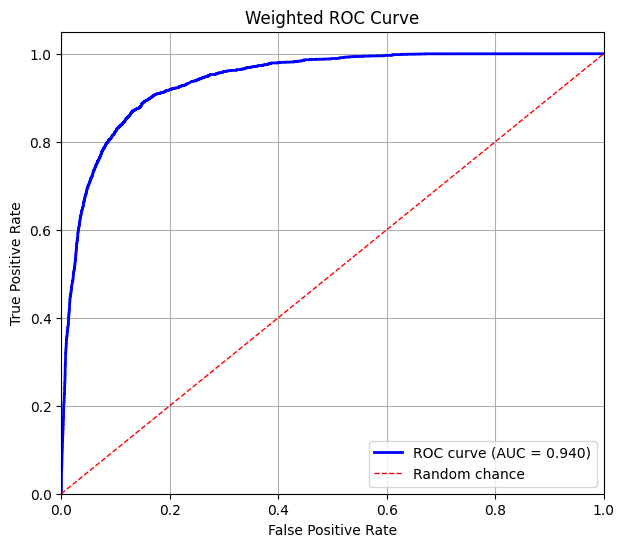

In [25]:
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
print("ROC AUC:", roc_auc)

fpr, tpr, thresholds = roc_curve(y_test, y_prob, sample_weight=w_test)

# Plot ROC curve
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

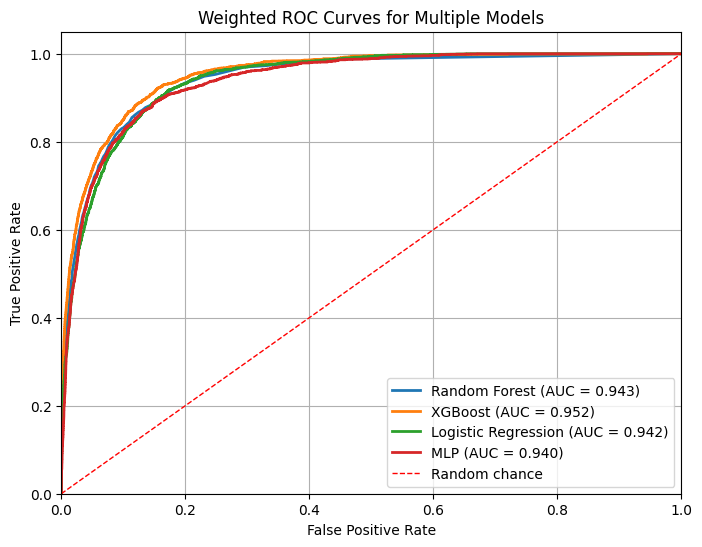

In [28]:
# Plot 4 models toghether
models = {
    "Random Forest": clf,
    "XGBoost": xgb_clf,
    "Logistic Regression": lr_clf,
    "MLP": mlp_clf
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_prob, sample_weight=w_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob, sample_weight=w_test)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

# Plot random chance line
plt.plot([0,1], [0,1], color='red', lw=1, linestyle='--', label='Random chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Weighted ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [66]:
summary = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'XGBoost', 'MLP'],
    'Precision (pos)': [0.73, 0.27, 0.33, 0.63],
    'Recall (pos)': [0.38, 0.90, 0.88, 0.47],
    'F1-score (pos)': [0.50, 0.42, 0.48, 0.54],
    'Accuracy': [0.95, 0.84, 0.88, 0.95],
    'Macro F1': [0.74, 0.66, 0.70, 0.76],
    'ROC-AUC': [0.943, 0.942, 0.952, 0.940]  # Fill in your ROC-AUC scores if available
})

summary

,Model,Precision (pos),Recall (pos),F1-score (pos),Accuracy,Macro F1,ROC-AUC
0,Random Forest,0.73,0.38,0.50,0.95,0.74,0.943
1,Logistic Regression,0.27,0.90,0.42,0.84,0.66,0.942
2,XGBoost,0.33,0.88,0.48,0.88,0.70,0.952
3,MLP,0.63,0.47,0.54,0.95,0.76,0.940
